# Introduction

This workbook fits a Gaussian Process model to the Random and Sobol data. 

In [32]:
import GPy
import pandas as pd
import patsy as pt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
import re
import pymc3 as pm
import matplotlib.ticker as tk
import re
from sklearn.model_selection import KFold, StratifiedKFold

In [33]:
df = pd.read_csv('results/all_results_average.csv')


df = df.rename(columns={'lag_time': 't', 'n_components': 'm', 'n_clusters': 'n', 'test_score': 'y'}).\
loc[:, ['basis', 'method', 'y', 't', 'm', 'n']]

to_scale = ['m', 'n', 't']
scaler = preprocessing.MinMaxScaler()
vars_scaled = pd.DataFrame(scaler.fit_transform(df.loc[:, to_scale]), columns=[x+'_s' for x in to_scale])
df = df.join(vars_scaled)

In [34]:
idx = (df['method'] == 'random') & (~df['basis'].isin(['ff_all_ang', 'ff_bb_ang', 'ff_re_ang', 'chi_tor']))
X = df.loc[idx, :].filter(regex='(_s$|basis)')
y = df.loc[idx, 'y']

In [35]:
X.groupby('basis').count()

,m_s,n_s,t_s
basis,,,
all_tor,199,199,199
alpha_angle,197,197,197
ca_cont,199,199,199
close-h_cont,200,200,200
close_cont,199,199,199
drid,200,200,200
hb_pairs,199,199,199
kappa_angle,200,200,200
ppo_tor,149,149,149


In [36]:
X_c = pt.dmatrix('0+ t_s + m_s + n_s+C(basis)', data=X, return_type='dataframe')
X_c = X_c.rename(columns=lambda x: re.sub('C|\\(|\\)|\\[|\\]','',x))
# X_c = X_c.rename(columns=lambda x: re.sub('T\\.','_',x))

# X_c = X_c.rename(columns=lambda x: x[:15])
# X_c = X_c.iloc[:, 1:X_c.shape[1]] # Remove intercept

In [37]:
X_c.head()

,basisall_tor,basisalpha_angle,basisca_cont,basisclose-h_cont,basisclose_cont,basisdrid,basishb_pairs,basiskappa_angle,basisppo_tor,t_s,m_s,n_s
1567,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.861723,0.777778,0.418769
1568,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.119238,0.666667,0.662967
1569,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.505010,0.000000,0.575177
1570,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.889780,0.666667,0.622603
1571,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.761523,0.666667,0.929364


## Priors

In [38]:
def gamma(alpha, beta):
    def g(x):
        return pm.Gamma(x, alpha=alpha, beta=beta)
    return g

def hcauchy(beta):
    def g(x):
        return pm.HalfCauchy(x, beta=beta)
    return g


In [39]:
def fit_model_1(y, X, kernel_type='rbf'):
    """
    function to return a pymc3 model
    y : dependent variable
    X : independent variables
    prop_Xu : number of inducing varibles to use
    
    X, y are dataframes. We'll use the column names. 
    """
    with pm.Model() as model:
        # Covert arrays
        X_a = X.values
        y_a = y.values
        X_cols = list(X.columns)
        
        # Globals
        prop_Xu = 0.1
        l_prior = gamma(1, 0.05)
        eta_prior = hcauchy(2)
        sigma_prior = hcauchy(2)

        # Kernels
        # 3 way interaction
        eta = eta_prior('eta')
        cov = eta**2
        for i in range(X_a.shape[1]):
            var_lab = 'l_'+X_cols[i]
            if kernel_type=='RBF':
                cov = cov*pm.gp.cov.ExpQuad(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='Exponential':
                cov = cov*pm.gp.cov.Exponential(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='M52':
                cov = cov*pm.gp.cov.Matern52(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='M32':
                cov = cov*pm.gp.cov.Matern32(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])

        # Covariance model
        cov_tot = cov 

        # Model
        gp = pm.gp.MarginalSparse(cov_func=cov_tot, approx="FITC")

        # Noise model
        sigma_n =sigma_prior('sigma_n')

        # Inducing variables
        num_Xu = int(X_a.shape[0]*prop_Xu)
        Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X_a)

        # Marginal likelihood
        y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a,Xu=Xu, noise=sigma_n)
        mp = pm.find_MAP()
        
    return gp, mp, model

In [40]:
X.head()

,basis,m_s,n_s,t_s
1567,all_tor,0.777778,0.418769,0.861723
1568,all_tor,0.666667,0.662967,0.119238
1569,all_tor,0.000000,0.575177,0.505010
1570,all_tor,0.666667,0.622603,0.889780
1571,all_tor,0.666667,0.929364,0.761523


In [ ]:
# Inputs
exp_labs = ['Categorical']
predictors = [X_c]
targets = [y]
kernels =  ['M32' ]

# Outputs
pred_dfs = []

# iterator
kf = StratifiedKFold(n_splits=10)

for i in range(len(exp_labs)):
    
    for idx, (train_idx, test_idx) in enumerate(kf.split(X.values, X['basis'])):
        # subset dataframes
        y_train = targets[i].iloc[train_idx]
        X_train = predictors[i].iloc[train_idx, :]
        y_test = targets[i].iloc[test_idx]
        X_test = predictors[i].iloc[test_idx, :]  
        
        gp, mp, model = fit_model_1(y=y_train, X=X_train, kernel_type=kernels[i])

        # Test
        with model:
            # predict latent
            mu, var = gp.predict(X_test.values, point=mp, diag=True,pred_noise=False)
            sd_f = np.sqrt(var)
            # predict target
            _, var = gp.predict(X_test.values, point=mp, diag=True,pred_noise=True)
            sd_y = np.sqrt(var)
            
        res = pd.DataFrame({'f_pred': mu, 'sd_f': sd_f, 'sd_y': sd_y, 'y': y_test.values})
        res.loc[:, 'kernel'] = kernels[i]
        res.loc[:, 'm_type'] = exp_labs[i]
        res.loc[:, 'fold_num'] = idx
        
        pred_dfs.append(pd.concat([X_test.reset_index(), res.reset_index()], axis=1))

pred_dfs = pd.concat(pred_dfs)
    

 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  0%|          | 0/5000 [00:00<?, ?it/s] /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
logp = 811.47, ||grad|| = 0.037335: 100%|██████████| 68/68 [00:34<00:00,  1.99it/s]   
INFO (theano.gof.compilelock): 

In [10]:
null_mu = np.mean(y)
null_sd = np.std(y)

def ll(f_pred, sigma_pred, y_true):
    tmp = 0.5*np.log(2*np.pi*sigma_pred**2)
    tmp += (f_pred-y_true)**2/(2*sigma_pred**2)
    return tmp

sll = ll(pred_dfs['f_pred'], pred_dfs['sd_y'], pred_dfs['y'])
sll = sll - ll(null_mu, null_sd, pred_dfs['y'])
pred_dfs['msll'] = sll
pred_dfs['smse'] = (pred_dfs['f_pred']-pred_dfs['y'])**2/np.var(y)



In [11]:
pred_dfs.to_pickle('results/all_chi_gp_cross_validation.p')

In [12]:
msll = pred_dfs.groupby(['m_type', 'kernel'])['msll'].mean()
smse = pred_dfs.groupby(['m_type', 'kernel'])['smse'].mean()

In [13]:
summary = pd.DataFrame(smse).join(other=pd.DataFrame(msll), on=['m_type', 'kernel'], how='left')
summary.to_csv('results/all_chi_gp_fit_summary.csv')

In [31]:
mp

{'eta_log__': array(-0.31754707),
 'l_basisT.alpha_angle_log__': array(2.68788917),
 'l_basisT.ca_cont_log__': array(2.15570923),
 'l_basisT.close-h_cont_log__': array(1.51031767),
 'l_basisT.close_cont_log__': array(1.35880491),
 'l_basisT.drid_log__': array(1.50718425),
 'l_basisT.hb_pairs_log__': array(1.64229626),
 'l_basisT.kappa_angle_log__': array(2.2441078),
 'l_basisT.ppo_tor_log__': array(1.69193628),
 'l_t_s_log__': array(0.31185912),
 'l_m_s_log__': array(0.54405226),
 'l_n_s_log__': array(1.76282608),
 'sigma_n_log__': array(-2.03840391),
 'eta': array(0.72793241),
 'l_basisT.alpha_angle': array(14.70061269),
 'l_basisT.ca_cont': array(8.63401149),
 'l_basisT.close-h_cont': array(4.52816903),
 'l_basisT.close_cont': array(3.89153979),
 'l_basisT.drid': array(4.51400258),
 'l_basisT.hb_pairs': array(5.16702074),
 'l_basisT.kappa_angle': array(9.43199655),
 'l_basisT.ppo_tor': array(5.42998451),
 'l_t_s': array(1.36596224),
 'l_m_s': array(1.72297468),
 'l_n_s': array(5.8288

## Model fit

In [14]:
gp, mp, model = fit_model_1(y=y, X=X_c, kernel_type='M32')

logp = 912.53, ||grad|| = 0.018447: 100%|██████████| 74/74 [00:35<00:00,  2.09it/s]   


In [15]:
# Create new matrix
chi_new, m_new, n_new, t_new = np.meshgrid(np.unique(X['basis'].values), np.linspace(0, 1, 10), np.linspace(0, 1, 20), np.linspace(0, 1, 20))
X_new = np.array([chi_new.flatten(), m_new.flatten(), n_new.flatten(), t_new.flatten()]).T

# One hot encoding
X_new = pd.DataFrame(X_new, columns=['basis', 'm_s', 'n_s', 't_s'])
for x in ['m_s', 'n_s', 't_s']:
    X_new.loc[:, x] = X_new.loc[:, x].astype(float) 
X_new_c = pt.dmatrix('t_s + m_s + n_s+ C(basis)', data=X_new, return_type='dataframe')
X_new_c = X_new_c.rename(columns=lambda x: re.sub('C|\\(|\\)|\\[|\\]','',x))
X_new_c = X_new_c.iloc[:, 1:]

# Make predictions
with model:
    # predict latent
    mu, var = gp.predict(X_new_c.values, point=mp, diag=True,pred_noise=True)
    mu, var2 = gp.predict(X_new_c.values, point=mp, diag=True,pred_noise=False)
# put predictions in dataframe
pred_df = X_new_c.copy(deep=True)
pred_df['y'] = mu
pred_df['y_err'] = 2*np.sqrt(var)
pred_df['f_err'] = 2*np.sqrt(var2)
pred_df['type'] = 'prediction'

# put original observations in same format as above
obs_df = X_c.copy(deep=True)
obs_df['y'] = y.values
obs_df['y_err'] = 0
obs_df['f_err'] = 0
obs_df['type'] = 'observed'

# Combine predictions and observations and rescale variables. 
all_df = pd.concat([pred_df,obs_df], axis=0)
tmp = scaler.inverse_transform(all_df.loc[:, ['m_s', 'n_s', 't_s']])
for i, x in enumerate(to_scale):
    all_df.loc[:, x] = tmp[:, i]

## Pred vs Obs

In [18]:
with model:
# predict latent
    mu, var = gp.predict(X_c.values, point=mp, diag=True,pred_noise=True)
    mu, var2 = gp.predict(X_c.values, point=mp, diag=True,pred_noise=False)

In [22]:
obs_df['mu'] = mu
obs_df['f_err'] = 2*np.sqrt(var2)
obs_df['y_err'] = 2*np.sqrt(var)
obs_df['basis'] = X['basis']

In [23]:
obs_df.head()

,basisT.alpha_angle,basisT.ca_cont,basisT.close-h_cont,basisT.close_cont,basisT.drid,basisT.hb_pairs,basisT.kappa_angle,basisT.ppo_tor,t_s,m_s,n_s,y,y_err,f_err,type,mu,basis
1567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.861723,0.777778,0.418769,1.844088,0.264326,0.044966,observed,1.674224,all_tor
1568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.119238,0.666667,0.662967,1.876990,0.264873,0.048082,observed,1.693892,all_tor
1569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.505010,0.000000,0.575177,1.769319,0.266490,0.056312,observed,1.904958,all_tor
1570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.889780,0.666667,0.622603,1.589727,0.264457,0.045731,observed,1.674850,all_tor
1571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.761523,0.666667,0.929364,1.671500,0.264739,0.047337,observed,1.671055,all_tor


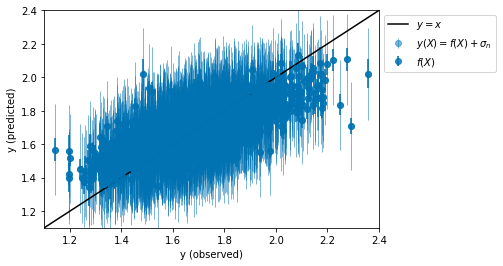

In [19]:
with sns.plotting_context(font_scale=1.25):
    lims = (1.1, 2.4)
    cols = sns.color_palette('colorblind')    
    g = sns.
    ax.errorbar(y.values, mu, 2*np.sqrt(var),  color=cols[0], alpha=0.5, marker='o',
                label='$y(X) = f(X) + \sigma_n$', lw=0, elinewidth=1)
    ax.errorbar(y.values, mu, 2*np.sqrt(var2), color=cols[0], marker='o',
                label='$f(X)$', lw=0, elinewidth=2, alpha=0.8)
    ax.plot(lims, lims, label='$y=x$', color='k')
    ax.set_ylim(lims)
    ax.set_xlim(lims)
    ax.legend(bbox_to_anchor=(1,1))
    ax.set_ylabel('y (predicted)')
    ax.set_xlabel('y (observed)')
    plt.savefig('figures/all_chi_gp_pred-vs-obs.pdf', bbox_inches='tight')

## Fit Bayesian model

In [123]:
def fit_model_2(y, X, kernel_type='M32', n=1000, n_chains=2):
    """
    function to return a pymc3 model
    y : dependent variable
    X : independent variables
    prop_Xu : number of inducing varibles to use
    
    X, y are dataframes. We'll use the column names. 
    """
    with pm.Model() as model:
        # Covert arrays
        X_a = X.values
        y_a = y.values
        X_cols = list(X.columns)
        
        # Globals
        prop_Xu = 0.1
        l_prior = gamma(1, 0.05)
        eta_prior = hcauchy(2)
        sigma_prior = hcauchy(2)

        # Kernels
        # 3 way interaction
        eta = eta_prior('eta')
        cov = eta**2
        for i in range(X_a.shape[1]):
            var_lab = 'l_'+X_cols[i]
            if kernel_type=='RBF':
                cov = cov*pm.gp.cov.ExpQuad(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='Exponential':
                cov = cov*pm.gp.cov.Exponential(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='M52':
                cov = cov*pm.gp.cov.Matern52(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='M32':
                cov = cov*pm.gp.cov.Matern32(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])

        # Covariance model
        cov_tot = cov 

        # Model
        gp = pm.gp.MarginalSparse(cov_func=cov_tot, approx="FITC")

        # Noise model
        sigma_n =sigma_prior('sigma_n')

        # Inducing variables
        num_Xu = int(X_a.shape[0]*prop_Xu)
        Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X_a)

        # Marginal likelihood
        y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a,Xu=Xu, noise=sigma_n)
        trace = pm.sample(draws=n, chains=n_chains, cores=1)
        
    return gp, trace, model

In [124]:
gp, trace, model = fit_model_2(y=y, X=X, kernel_type='M32')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_n, l_t_s, l_n_s, l_m_s, eta]


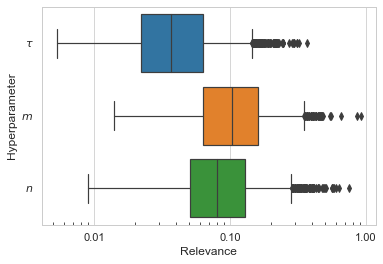

In [131]:
df_trace = pd.DataFrame({x : trace.get_values(x) for x in trace.varnames if x[-5:]!='log__'})
df_trace.columns = [r'$\eta$',r'$m$', r'$n$', r'$\tau$', r'$\sigma_n$']
df_trace.head()

len_labs = [ r'$\tau$', r'$m$', r'$n$']

relevance = pd.DataFrame(1/df_trace.loc[:, len_labs].values, columns=len_labs)
relevance_m = relevance.melt(var_name='Hyperparameter', value_name='Relevance')
with sns.plotting_context('paper', font_scale=1.25):
    sns.set_style('whitegrid')
    ax = sns.boxplot(data=relevance_m, x='Relevance', y='Hyperparameter', whis=2)
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(tk.StrMethodFormatter('{x:4.2f}'))
    ax.xaxis.set_minor_locator(tk.LogLocator(base=10.0, subs='auto', numdecs=4))
    ax.tick_params(which='minor', axis='x', bottom=True, direction='in')
    plt.savefig('figures/ppo_gp_bayes_relevance.png', dpi=450 )

In [132]:
all_params = relevance.join(df_trace.loc[:, [r'$\eta$', r'$\sigma_n$']])

all_params.melt(var_name='Parameter').groupby('Parameter')['value'].\
aggregate(**{"Median": lambda x: "{:4.2f}".format(np.median(x)), 
             "95% CI": lambda x: "({0:4.2f}, {1:4.2f})".format(np.quantile(x, 0.025),np.quantile(x, 0.975))}).\
reset_index().\
to_csv('results/ppo_gp_bayes_posterior.csv', index=False)
